In [1]:
import numpy as np
import librosa
import scipy
from scipy.io import wavfile
import os, time, csv, datetime
from librosa import display
import matplotlib.pyplot as plt 
from numpy import diff
#import pyworld as pw
import h5py

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
parent_dir = os.getcwd()
dataset_dir = os.path.join(parent_dir,'RAVDESS')
#dataset_rec = os.path.join(parent_dir,'RECORDINGSS')
#print(dataset_dir, dataset_rec)

In [3]:
length_wave_max = 85346 #maximum length of the audio waves
 
emo_label ={0: 'neutral', 1:'calm', 2: 'happy',
            3: 'sad',   4: 'angry', 5: 'fearful',
            6: 'disgust', 7: 'surprise'}

features = []
labels  = []
max_frame_len = 442 #maximum length of the audio waves
emotionset = [0,1, 2, 3, 4, 5, 6, 7]


In [4]:
#Preparing training set from RAVDESS

totalem = range(len(emotionset))
tr_wave = []
tr_lab = []
# val_wave = []
# val_lab = []
test_wave = []
test_lab = []

for emnum in totalem:   

    _waveform = []
    _labels  = []
    emotion = emotionset[emnum]
    print(emotion)
    print('Reading emotion #' + str(emotion) + ' :' + emo_label[emotion] + '...')
    
    emotion_dir = os.path.join(dataset_dir, str(emotion))
    print(emotion_dir)
    
    file_list = os.listdir(emotion_dir)
    sett = range(len(file_list))
    
    for filenum in sett:
        
        #Load the dataset 
        y, sr = librosa.load(os.path.join(emotion_dir, file_list[filenum]),dtype=np.float32) 
        
        # truncate or zero-pad the signal
        y = y[:length_wave_max]
        if len(y) < length_wave_max:
            y = np.concatenate([y, np.zeros(length_wave_max-len(y))])
            
        _waveform.append(y)
        _labels.append(emotion)
        
        waveform = np.array(_waveform)
        labels = np.array(_labels)
    
    X_train = waveform
    y_train = labels
    X_train, X_test, y_train, y_test = train_test_split(waveform, labels, test_size=0.3, random_state=42) 
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=10) 
    
    print('Train',X_train.shape)
    tr_wave.append(X_train)
    tr_lab.append(y_train)
    
#     print('Val',X_val.shape)
#     val_wave.append(X_val)
#     val_lab.append(y_val)
    
    #print('Test',X_test.shape)
    test_wave.append(X_test)
    test_lab.append(y_test)


0
Reading emotion #0 :neutral...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/0
Train (131, 85346)
1
Reading emotion #1 :calm...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/1
Train (263, 85346)
2
Reading emotion #2 :happy...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/2
Train (263, 85346)
3
Reading emotion #3 :sad...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/3
Train (263, 85346)
4
Reading emotion #4 :angry...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/4
Train (263, 85346)
5
Reading emotion #5 :fearful...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/5
Train (263, 85346)
6
Reading emotion #6 :disgust...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/6
Train (134, 85346)
7
Reading emotion #7 :surprise...
/Users/apple/HOME WORK/SRU/PROJECT/RAVDESS/7
Train (134, 85346)


In [5]:
tr_w = np.array(tr_wave); tr_w = np.vstack((tr_w[0], tr_w[1], tr_w[2], tr_w[3], tr_w[4], tr_w[5], tr_w[6], tr_w[7] ))
tr_l = np.array(tr_lab);  tr_l = np.hstack((tr_l[0], tr_l[1], tr_l[2], tr_l[3], tr_l[4], tr_l[5], tr_l[6], tr_l[7] )) 
print('Total Training set',tr_w.shape) 


test_w = np.array(test_wave); test_w = np.vstack((test_w[0], test_w[1], test_w[2], test_w[3], test_w[4], test_w[5], test_w[6], test_w[7] ))
test_l = np.array(test_lab);  test_l = np.hstack((test_l[0], test_l[1], test_l[2], test_l[3], test_l[4], test_l[5], test_l[6], test_l[7] )) 
print('Total Test set',test_w.shape) 

#plt.figure(1, figsize=(8,2))
#plt.subplot(121); plt.plot(tr_w[334,:])
#plt.subplot(122); plt.plot(test_w[100,:])
#plt.tight_layout()

Total Training set (1714, 85346)
Total Test set (738, 85346)


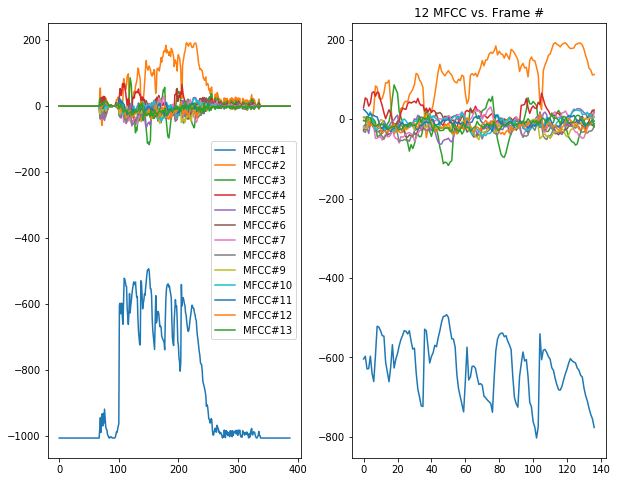

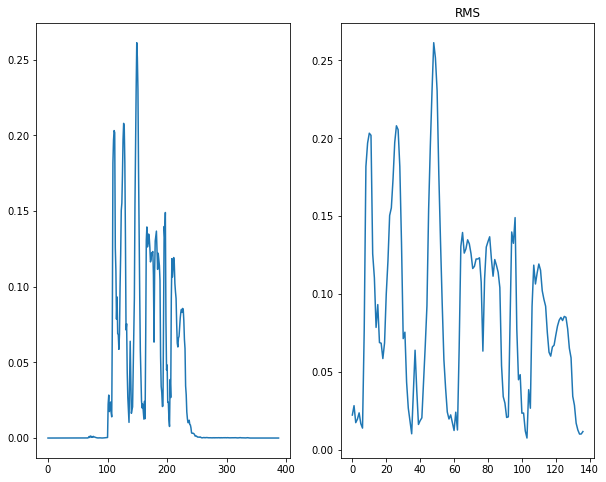

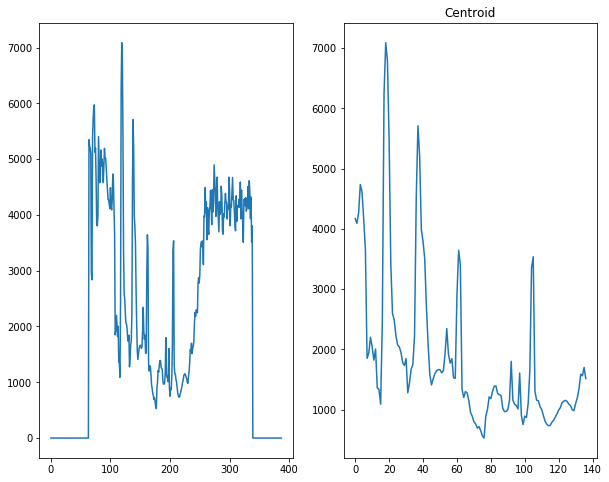

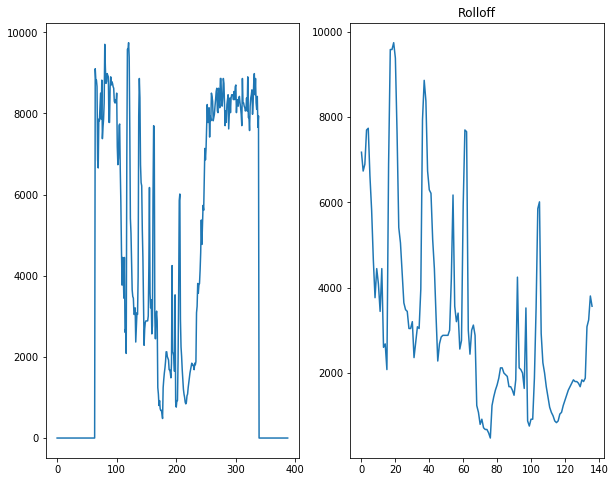

In [6]:
frame_t = 0.025 #25ms 
frame_n = round(sr*frame_t) 

hop_n = round(0.01*sr) #10ms 

tr_features = []; tr_labels  = []
test_features = []; test_labels = [] 

for sets in range(2): 
    if sets == 0:
        mydata = tr_w
        #print('Feature Extraction for Training Set', sets)
    if sets == 1:
        mydata = test_w
        #print('Feature Extraction for Test Set', sets)
    
    ind=0
    for wavs in range(len(mydata)): 
        ind+=1
        #print(ind,end=" ")
        y = mydata[wavs,:]   
 
        mfcc_num = 13 
        Ethresh = 0.01
        
        S, phase = librosa.magphase(librosa.stft(y=y,win_length=frame_n, hop_length=hop_n))
        rmst = (librosa.feature.rmse(S=S,frame_length=frame_n, hop_length=hop_n))
        
        Elocs = np.where(rmst>Ethresh)[1] #all places where greater than 0.05
        Eloc = np.arange(Elocs[0],Elocs[-1]+1) #only chop off ends, keep middle zeros for silence frames
        rms = rmst[:,Eloc]
        
#----------------------------------------------------------
        #MFCC per frame
        MFCCt = librosa.feature.mfcc(y=y, sr=sr, n_fft=frame_n, hop_length=hop_n, n_mfcc=mfcc_num)
        MFCC = MFCCt[:, Eloc]
#         print('Shape of MFCC', MFCC.shape)

#----------------------------------------------------------
        _cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_n, hop_length=hop_n)
        cent = _cent[:,Eloc]
#----------------------------------------------------------

        _rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=frame_n, hop_length=hop_n)
        rolloff = _rolloff[:,Eloc]
#---------------------------------------------------------

        zcrt = librosa.feature.zero_crossing_rate(y=y, frame_length=frame_n, hop_length=hop_n)
        zcr = zcrt[:,Eloc]
#----------------------------------------------------------
 
        #Plot the sample features 
        if sets == 0 and wavs == 0:
            plt.figure(1, figsize=(10,8))
            for i in range(13):
                plt.subplot(121)
                plt.plot(MFCCt[i,:],label="MFCC#{}".format(i+1))
                plt.legend()
                plt.subplot(122)
                plt.plot(MFCC[i,:],label="MFCC#{}".format(i+1))
                plt.title('12 MFCC vs. Frame #')
                
                
            plt.figure(2, figsize=(10,8))
            plt.subplot(121)
            plt.plot(rmst[0,:],label='ZCR')
            plt.subplot(122)
            plt.plot(rms[0,:],label='ZCR')
            plt.title('RMS')
            
            plt.figure(3, figsize=(10,8))
            plt.subplot(121)
            plt.plot(_cent[0,:],label='ZCR')
            plt.subplot(122)
            plt.plot(cent[0,:],label='ZCR')
            plt.title('Centroid')
 
            plt.figure(4, figsize=(10,8))
            plt.subplot(121)
            plt.plot(_rolloff[0,:],label='ZCR')
            plt.subplot(122)
            plt.plot(rolloff[0,:],label='ZCR')
            plt.title('Rolloff')
 
        MFCC = np.mean(MFCC, axis=1)
        zcr = np.mean(zcr, axis =1)
        rms = np.mean(rms, axis =1)
        cent = np.mean(cent, axis =1)
        rolloff = np.mean(rolloff, axis=1)  
#-------------------------------------------------------

        MFCC = np.reshape(MFCC, (len(MFCC),1)) 
        zcr = np.reshape(zcr, (len(zcr),1)) 
        rms = np.reshape(rms, (len(rms),1)) 
        cent = np.reshape(cent, (len(cent),1)) 
        rolloff = np.reshape(rolloff, (len(rolloff),1))
        
#----------------------------------------------------------     

        concat = np.vstack((MFCC,zcr, rms, cent, rolloff))
        
        if sets == 0:
           tr_features.append(concat[:,0])   
           tr_labels.append(tr_l[wavs])
        if sets == 1: 
           test_features.append(concat[:,0])
           test_labels.append(test_l[wavs])

In [7]:
#pip install 'librosa==0.6.3'

Train -Audio x Features x Frames (1714, 17)
Train -Labels of audio (1714,)
Test -Audio x Features x Frames (738, 17)
Test -Labels of audio (738,)


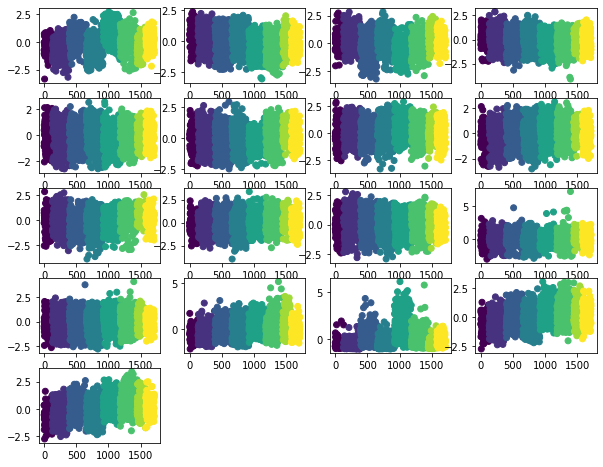

In [8]:
tr_fea = np.array(tr_features); tr_lab = np.array(tr_labels)
print('Train -Audio x Features x Frames',tr_fea.shape)
print('Train -Labels of audio',(tr_lab.shape))  

test_fea = np.array(test_features); test_lab = np.array(test_labels)
print('Test -Audio x Features x Frames',test_fea.shape)
print('Test -Labels of audio',(test_lab.shape))  

#Normalize the training features: 
scaler = preprocessing.StandardScaler().fit(tr_fea)
tr_fea = scaler.transform(tr_fea) 

for i in range(tr_fea.shape[1]): 
    plt.figure(1, figsize=(10,8))
    plt.subplot(5,4,i+1)
    plt.scatter(np.arange(tr_fea.shape[0]),tr_fea[:,i],c=tr_lab);


# ONE vs ONE CLASSIFIER(RBF kernel)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Training Score 0.6242707117852976
Score 0.5271002710027101
Accuracy 0.5271002710027101
Confusion Matrix
 [[39 23 17 26  1  8  2  2]
 [12 72  6 23  0  8  2  4]
 [ 2  0 49  8 11 15  1  2]
 [ 1  7  1 38  4  7  1  1]
 [ 0  0  7  0 73  7  2  0]
 [ 0  1 14  9  8 42  1  4]
 [ 2  6  5  7 10  9 41 10]
 [ 1  4 14  2  6 17  8 35]]


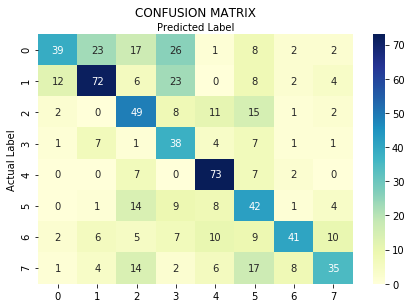

In [9]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
 
clf =  (OneVsOneClassifier(svm.SVC(kernel = 'rbf', gamma = 'auto',C=1,class_weight = 'balanced',tol = 1e-15, verbose = True))).fit(tr_fea, tr_lab)
print("")
print('Training Score',clf.score(tr_fea, tr_lab)) 

test_fea_transformed = scaler.transform(test_fea)
print('Score',clf.score(test_fea_transformed, test_lab)) 
  
test_lab_pred = clf.predict(test_fea_transformed)
acc = accuracy_score(test_lab_pred,test_lab)
print('Accuracy',acc)
#print(test_lab_pred)
#print(test_lab)
cm_svm = confusion_matrix(test_lab_pred, test_lab)

#cm_svm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]

#print(confusion_matrix(test_lab_pred, test_lab))
print('Confusion Matrix\n', cm_svm) 
#plot_confusion_matrix(test_lab, test_lab_pred, classes=emotionclassname, normalize=True, title='Normalized confusion matrix')

#plt.savefig('norm4emo.png')

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(cm_svm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# SVM One vs One (Linerar Kernel)

Training Score 0.48016336056009334
Test Score 0.4444444444444444
Accuracy 0.4444444444444444
Confusion Matrix
 [[17  7  7  4  0  1  2  2]
 [19 71  3 43  1 11  3  9]
 [ 8  3 52  9 16 20  5 13]
 [10 19 12 37  7 12  4  1]
 [ 0  0 18  4 73 13  4  5]
 [ 1  4 19 11  8 42  7 13]
 [ 1  4  0  5  6  3 29  8]
 [ 1  5  2  0  2 11  4  7]]


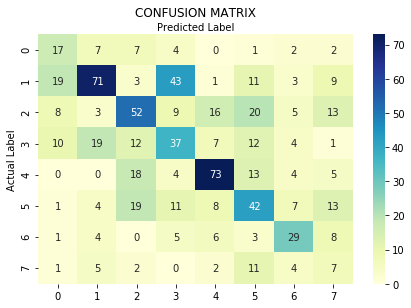

In [10]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
Eval_ovo = (SVC(kernel='linear', decision_function_shape='ovo'))
Eval_ovo.fit(tr_fea, tr_lab)
#Pred_ovo = Eval_ovo.predict(X_test)

#model.fit(tr_fea, tr_lab)

test_fea_transformed_ovo = scaler.transform(test_fea)
test_lab_pred_ovo = Eval_ovo.predict(test_fea_transformed_ovo)

from sklearn.metrics import accuracy_score
print('Training Score',Eval_ovo.score(tr_fea, tr_lab)) 
print('Test Score', Eval_ovo.score(test_fea_transformed_ovo, test_lab))
print('Accuracy', accuracy_score(test_lab_pred_ovo,test_lab))
print('Confusion Matrix\n', confusion_matrix(test_lab_pred_ovo, test_lab))

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(test_lab_pred_ovo, test_lab)), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Logistic Regression

Training Score 0.47024504084014
Test Score 0.42953929539295393
Accuracy 0.42953929539295393
Confusion Matrix
 [[16  3  4  2  0  0  2  2]
 [15 60  2 38  2  8  4  6]
 [ 7  5 46  8 14 23  5 11]
 [14 32 13 42  6 12  4  1]
 [ 0  2 21  4 75 12  5  7]
 [ 1  2 23 11  6 40  8 11]
 [ 2  4  1  6  8  6 26  8]
 [ 2  5  3  2  2 12  4 12]]


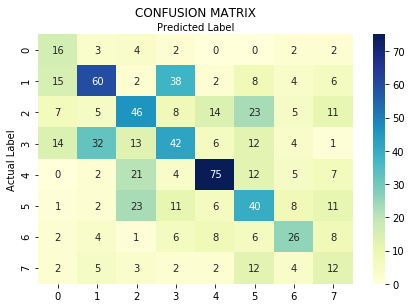

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(tr_fea, tr_lab)

test_fea_transformed = scaler.transform(test_fea)
test_lab_pred = logreg.predict(test_fea_transformed)

#y_pred = logreg.predict(test_fea_transformed)
from sklearn.metrics import accuracy_score
print('Training Score',logreg.score(tr_fea, tr_lab)) 
print('Test Score', logreg.score(test_fea_transformed, test_lab))
print('Accuracy', accuracy_score(test_lab_pred,test_lab))
print('Confusion Matrix\n', confusion_matrix(test_lab_pred, test_lab))

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(test_lab_pred, test_lab)), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Naive Bayes

Training Score 0.36406067677946324
Test Score 0.36449864498644985
Accuracy 0.36449864498644985
Confusion Matrix
 [[21 10 23 22  2  6  0  2]
 [18 61  8 40  4 22  7  8]
 [ 9 13 29 12 15 21  3  7]
 [ 4 12  0 16  3  2  1  1]
 [ 0  0 21  2 70 21  0  6]
 [ 0  3 14  5  3 24  8  7]
 [ 4 11  6  8  8  6 31 10]
 [ 1  3 12  8  8 11  8 17]]


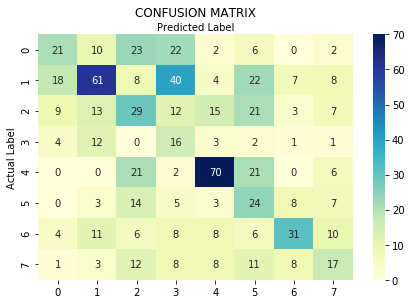

In [12]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(tr_fea, tr_lab)


test_fea_transformed_nb = scaler.transform(test_fea)
test_lab_pred_nb = gnb.predict(test_fea_transformed_nb)

from sklearn.metrics import accuracy_score
print('Training Score',gnb.score(tr_fea, tr_lab)) 
print('Test Score', gnb.score(test_fea_transformed_nb, test_lab))
print('Accuracy', accuracy_score(test_lab_pred_nb,test_lab))
print('Confusion Matrix\n', confusion_matrix(test_lab_pred_nb, test_lab))
# y_pred_test = gnb.predict(x_test)
# from sklearn.metrics import accuracy_score
# acc = accuracy_score(y_test,y_pred_test)

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(test_lab_pred_nb, test_lab)), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Decision Tree

Training Score 1.0
Test Score 0.4105691056910569
Accuracy 0.4105691056910569
Confusion Matrix
 [[19 11  4 14  2  5  2  0]
 [14 61  8 28  1  3  2  3]
 [ 5  5 38  7 16 16  5  9]
 [ 8 21  6 38  4 12 10  2]
 [ 0  0 14  5 60 16  4  4]
 [ 3  7 22  9 18 44  6 16]
 [ 4  6  7  4  4  7 22  3]
 [ 4  2 14  8  8 10  7 21]]


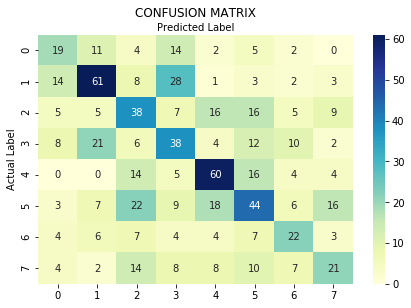

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(tr_fea, tr_lab)

test_fea_transformed_dt = scaler.transform(test_fea)
test_lab_pred_dt = dt.predict(test_fea_transformed_dt)

from sklearn.metrics import accuracy_score
print('Training Score',dt.score(tr_fea, tr_lab)) 
print('Test Score', dt.score(test_fea_transformed_dt, test_lab))
print('Accuracy', accuracy_score(test_lab_pred_dt,test_lab))
print('Confusion Matrix\n', confusion_matrix(test_lab_pred_dt, test_lab))
# y_pred2 = dt.predict(x_test)
# acc2 = accuracy_score(y_test,y_pred2)

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(test_lab_pred_dt, test_lab)), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# KNN

Training Score 0.8063010501750292
Test Score 0.5636856368563685
Accuracy 0.5636856368563685
Confusion Matrix
 [[38 15 16 22  1  4  2  2]
 [12 90  8 25  6 11  8  3]
 [ 2  1 68  9 11 15  3 10]
 [ 2  5  2 45  6 15  9  0]
 [ 1  0  4  1 73 10 10  5]
 [ 1  2  9  9 13 53  3  9]
 [ 1  0  2  1  2  4 21  1]
 [ 0  0  4  1  1  1  2 28]]


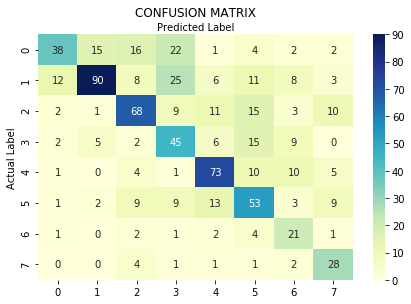

In [14]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3,algorithm='ball_tree')
clf.fit(tr_fea, tr_lab)

test_fea_transformed_knn = scaler.transform(test_fea)
test_lab_pred_knn = clf.predict(test_fea_transformed_knn)

from sklearn.metrics import accuracy_score
print('Training Score',clf.score(tr_fea, tr_lab)) 
print('Test Score', clf.score(test_fea_transformed_knn, test_lab))
print('Accuracy', accuracy_score(test_lab_pred_knn,test_lab))
print('Confusion Matrix\n', confusion_matrix(test_lab_pred_knn, test_lab))

# y_pred3 = clf.predict(x_test)
# acc3 =   accuracy_score(y_test,y_pred3)

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(test_lab_pred_knn, test_lab)), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Random Forest

Training Score 1.0
Test Score 0.5582655826558266
Accuracy 0.5582655826558266
Confusion Matrix
 [[23 10  6  8  0  4  1  0]
 [21 84  6 34  3 10  5  3]
 [ 5  2 69  7  9 11  2  9]
 [ 4 13  5 49  4 12  6  4]
 [ 0  0  7  1 79 11  4  5]
 [ 0  3 15 10 12 59  7 13]
 [ 3  1  3  3  6  3 30  5]
 [ 1  0  2  1  0  3  3 19]]


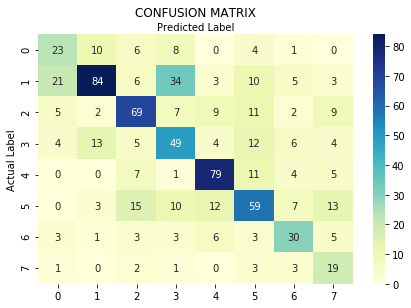

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(tr_fea, tr_lab)

test_fea_transformed_rf = scaler.transform(test_fea)
test_lab_pred_rf = model.predict(test_fea_transformed_rf)

from sklearn.metrics import accuracy_score
print('Training Score',model.score(tr_fea, tr_lab)) 
print('Test Score', model.score(test_fea_transformed_rf, test_lab))
print('Accuracy', accuracy_score(test_lab_pred_rf,test_lab))
print('Confusion Matrix\n', confusion_matrix(test_lab_pred_rf, test_lab))

import seaborn as sns
import pandas as pd
%matplotlib inline
class_names=[0,1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix(test_lab_pred_rf, test_lab)), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('CONFUSION MATRIX', Y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()